In [1]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import numpy as np
from fbprophet import Prophet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [2]:
df = pd.read_csv('series_de_tiempo-master/df_final.csv', index_col=0).reset_index()
df['month'] = pd.DatetimeIndex(df['index']).month
df = pd.concat([df, pd.get_dummies(df['month'])], axis=1)
df.drop(columns=['month'],inplace=True)
df.head(2)

index     Turistas   DEXBZUS  14 a 17 anos  18 a 24 anos  25 a 39 anos  40 a 59 anos  60 anos ou mais  Total  PIB  Ingreso  IPCA  tipo_cambio_a3500  temp_max  temp_min  1  2  3  4  5  6  7  8  9  10  11  12
0  2012-01-01  88318.57205  1.785035          24.8          16.4           7.2           4.0              2.0    7.9  3.7   1387.0  0.56           4.319719      31.8      20.7  1  0  0  0  0  0  0  0  0   0   0   0
1  2012-02-01  59186.46835  1.716800          24.8          16.4           7.2           4.0              2.0    7.9  3.4   1387.0  0.45           4.347507      30.0      19.7  0  1  0  0  0  0  0  0  0   0   0   0

In [3]:
reg_cols = []
for index, col in enumerate(df.columns[2:]):
    print(col)
    df['regr'+str(index)] = df[col]
    reg_cols.append('regr'+str(index))

reg_cols

DEXBZUS
14 a 17 anos
18 a 24 anos
25 a 39 anos
40 a 59 anos
60 anos ou mais
Total
PIB
Ingreso
IPCA
tipo_cambio_a3500
temp_max
temp_min
1
2
3
4
5
6
7
8
9
10
11
12


['regr0',
 'regr1',
 'regr2',
 'regr3',
 'regr4',
 'regr5',
 'regr6',
 'regr7',
 'regr8',
 'regr9',
 'regr10',
 'regr11',
 'regr12',
 'regr13',
 'regr14',
 'regr15',
 'regr16',
 'regr17',
 'regr18',
 'regr19',
 'regr20',
 'regr21',
 'regr22',
 'regr23',
 'regr24']

In [4]:
reg_cols = ['regr0','regr1','regr2','regr3','regr4','regr5','regr6',
            'regr7','regr8','regr9','regr10','regr11','regr12']

month_cols = ['regr13','regr14','regr15','regr16','regr17','regr18',
              'regr19','regr20','regr21','regr22','regr23','regr24']

In [5]:
# df['regr1'] = (df['Ingreso'] / df['DEXBZUS']) 
# df['regr2'] = df['temp_min']
# df['regr3'] = df['temp_max']
# df['regr4'] = df['tipo_cambio_a3500']
# df['regr5'] = df['DEXBZUS']

print(df.shape)
df = df.rename(columns={'index': 'ds', 'Turistas': 'y'})
df['ds'] = pd.to_datetime(df['ds'],format='%Y-%m-%d')

# Define threshold date.
threshold_date = pd.to_datetime('2019-02-01')
mask = df['ds'] <= threshold_date

# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]
print(df_train.shape)
print(df_test.shape)

df_test.head()

(98, 52)
(86, 2)
(12, 2)


ds             y
86 2019-03-01   61902.99982
87 2019-04-01   59837.00000
88 2019-05-01   69763.00000
89 2019-06-01   74633.00000
90 2019-07-01  103483.00000

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x=df_train.ds, y=df_train.y, name="Train")
)

fig.add_trace(
    go.Scatter(x=df_test.ds, y=df_test.y, name="Test", mode='lines')
)

fig.add_trace(go.Scatter(
    x=['2018-08-15','2018-08-15'],
    y=[0,100000],
    name = 'General Target',
    line=dict(color='grey', width=3, dash='dot'),
    mode = 'lines',
    showlegend=False),
)

# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)
fig.show()


In [7]:
# # Split the data and select `ds` and `y` columns.
# df_train = df[mask][['ds', 'y']]
# df_test = df[~ mask][['ds']]

# Time Series Decomposition
We begin the analysis by decomposing the (training) time series into the trend, seasonal and residual components.

In [8]:
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# from matplotlib import style
# style.use('dark_background')

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=df_train.set_index('ds'), 
    model='additive'
)

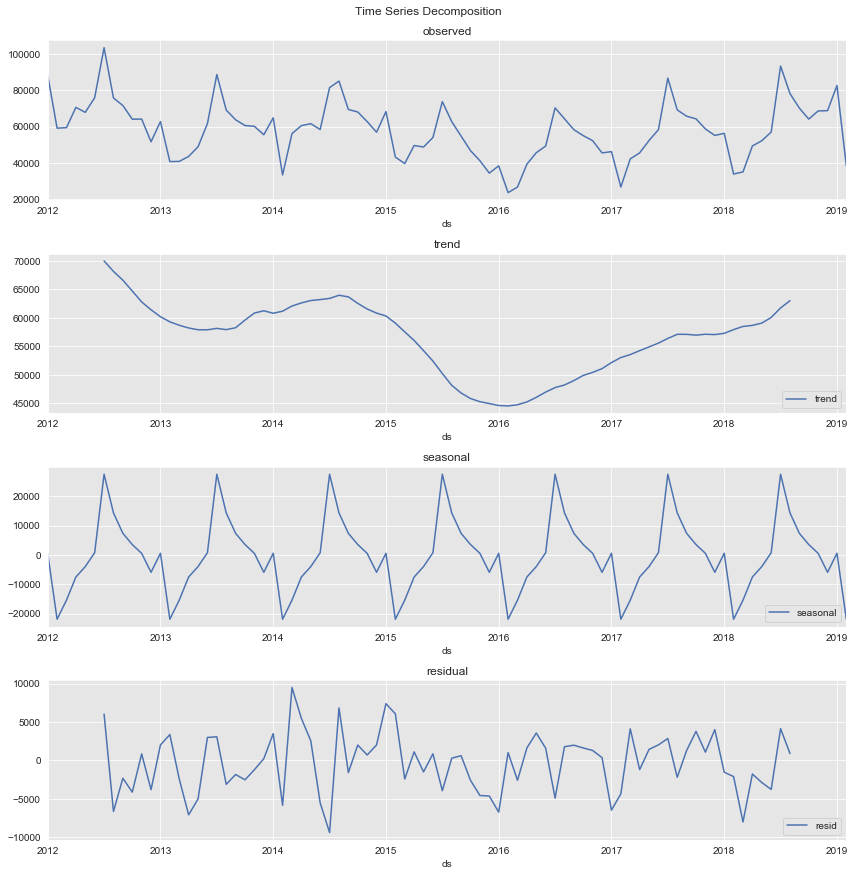

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# Observed time series.
decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
# Trend component. 
decomposition_obj.trend.plot( ax=ax[1])
ax[1].legend(loc='lower right')
ax[1].set(title='trend')
# Seasonal component. 
decomposition_obj.seasonal.plot( ax=ax[2])
ax[2].legend(loc='lower right')
ax[2].set(title='seasonal')
# Residual.
decomposition_obj.resid.plot( ax=ax[3])
ax[3].legend(loc='lower right')
ax[3].set(title='residual')

fig.suptitle('Time Series Decomposition', y=1.01)
plt.tight_layout()

# Basico prophet

In [11]:
# Fitting a Prophet model
model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95, 
        mcmc_samples = 500)
model.fit(df_train)

# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')
# Generate predictions. 
forecast = model.predict(df=future)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [12]:
forecast

ds         trend    yhat_lower     yhat_upper   trend_lower   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper        yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper          yhat
0  2012-01-01  73370.242677  62222.260498   96210.867885  67751.819682  78667.604787     6063.176406          -2228.702103          14295.113516   6063.176406  -2228.702103  14295.113516                   0.0                         0.0                         0.0  79433.419084
1  2012-02-01  72715.832960  33836.753535   66582.237413  67306.936706  77762.513958   -22242.357464         -29594.061003         -15095.933141 -22242.357464 -29594.061003 -15095.933141                   0.0                         0.0                         0.0  50473.475496
2  2012-03-01  72103.643224  38165.909793   73688.790991  66901.987494  76836.917715   -16030.687787         -23251.935470          -8436.359982 -16030.687787 -23251.935470  -8436.359982                   0.0                         0.0                         0.0  56072.955437
3  2012-04-01  71449.233506  45098.238142   80285.809588  66517.279339  75872.635885    -8008.141649         -16647.284045            -52.471882  -8008.141649 -16647.284045    -52.471882                   0.0                         0.0                         0.0  63441.091857
4  2012-05-01  70818.163989  48252.186745   82503.550418  66153.386670  75096.366098    -4879.658139         -13579.838601           3294.880374  -4879.658139 -13579.838601   3294.880374                   0.0                         0.0                         0.0  65938.505851
5  2012-06-01  70166.058823  53945.219835   90259.970201  65768.170181  74232.116273     1810.245827          -6997.516452          11190.786616   1810.245827  -6997.516452  11190.786616                   0.0                         0.0                         0.0  71976.304650
6  2012-07-01  69548.198822  79720.083517  113865.212544  65348.406617  73552.571606    27735.382027          19490.188640          35843.644355  27735.382027  19490.188640  35843.644355                   0.0                         0.0                         0.0  97283.580849
7  2012-08-01  68909.743487  60827.029100   96307.189705  64893.613874  72739.140740     9610.767809            952.294716          18174.632030   9610.767809    952.294716  18174.632030                   0.0                         0.0                         0.0  78520.511297
8  2012-09-01  68271.288153  55343.123870   90148.212505  64285.947343  72048.967393     5529.618422          -3972.832336          13859.707603   5529.618422  -3972.832336  13859.707603                   0.0                         0.0                         0.0  73800.906575
9  2012-10-01  67678.183455  53782.145480   88322.137621  63820.393578  71291.018772     2295.844028          -5904.474194          10771.144333   2295.844028  -5904.474194  10771.144333                   0.0                         0.0                         0.0  69974.027483
10 2012-11-01  67065.308601  52149.964840   86343.685917  63295.890726  70734.330975     1921.372860          -6586.351680          10021.159129   1921.372860  -6586.351680  10021.159129                   0.0                         0.0                         0.0  68986.681461
11 2012-12-01  66472.203903  44418.095803   78550.922728  62786.405228  70146.033436    -5147.466747         -12887.897329           3588.144660  -5147.466747 -12887.897329   3588.144660                   0.0                         0.0                         0.0  61324.737156
12 2013-01-01  65900.712416  48520.235948   83653.306762  62246.563041  69543.884805      218.586199          -8519.787588           9173.376533    218.586199  -8519.787588   9173.376533                   0.0                         0.0                         0.0  66119.298615
13 2013-02-01  65329.220929  24210.659248   57985.806269  61750.032166  68918.476806   -23552.299787     

In [13]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

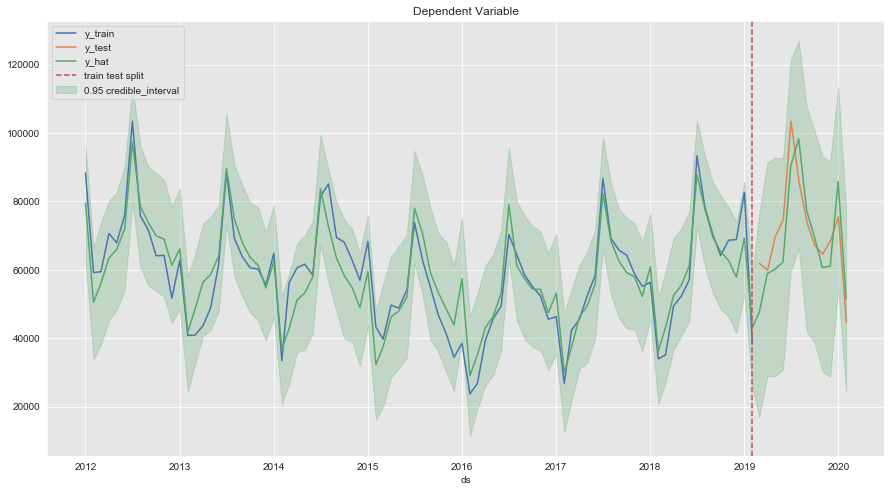

In [14]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

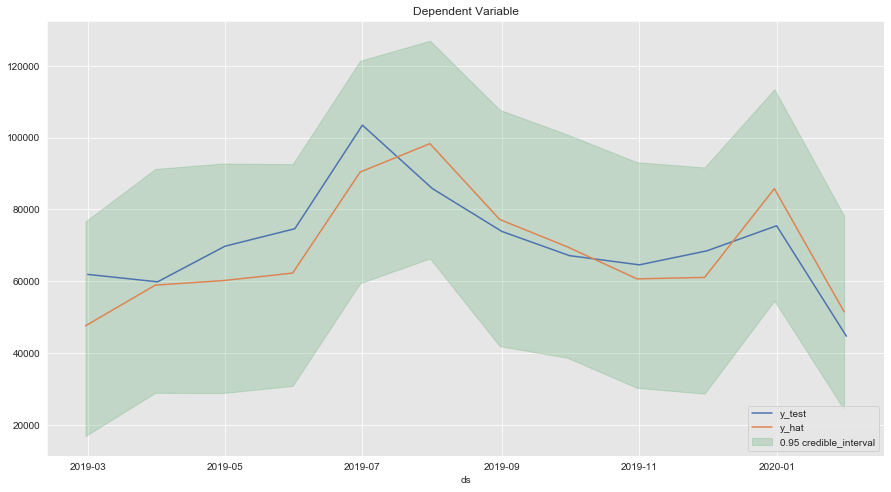

In [15]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

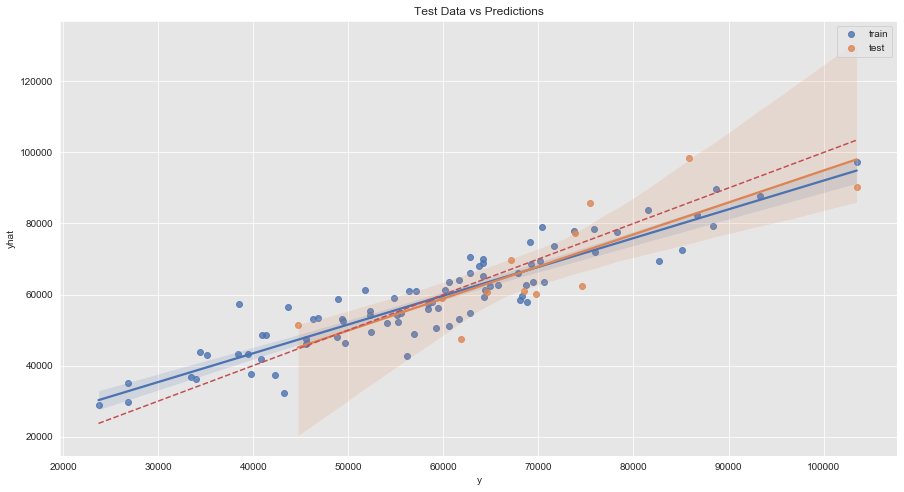

In [16]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))

r2 train: 0.8387617777252413
r2 test: 0.5538158377313072
------------------------------
mae train: 5051.6102563662425
mae test: 8082.879367709337


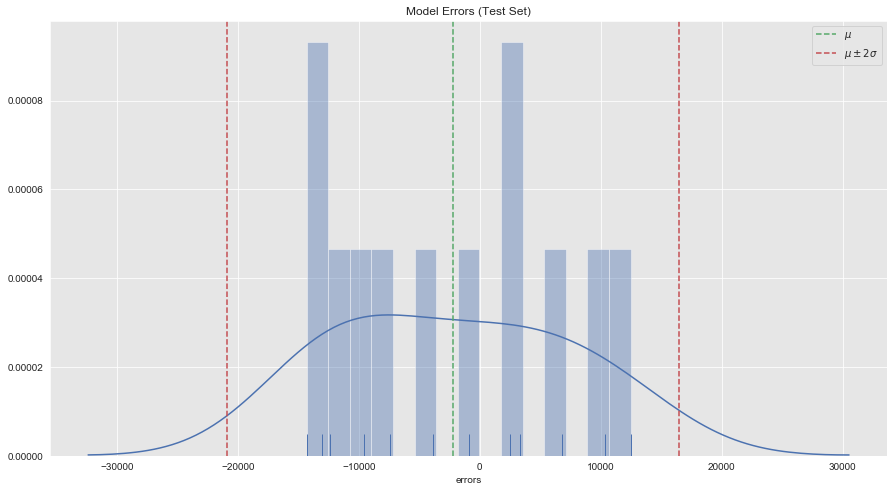

In [18]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

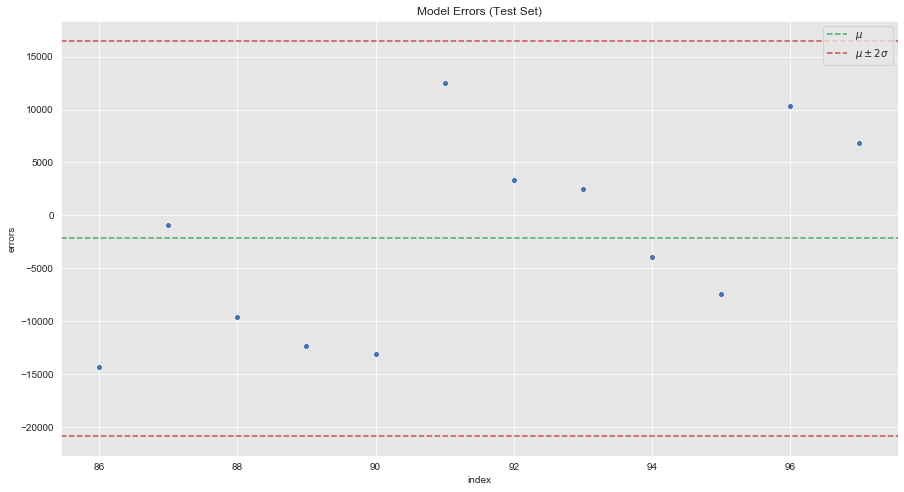

In [19]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

C:\Users\SanchezEdg\Anaconda3\envs\ev_nlp\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



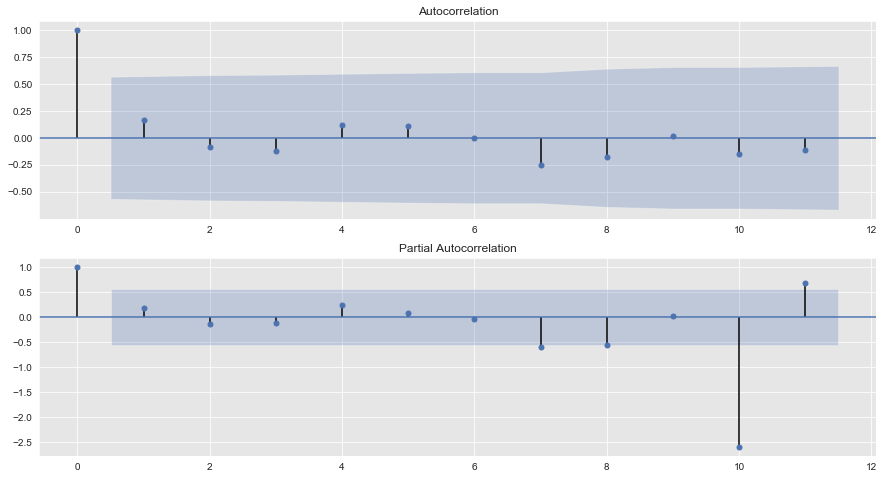

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

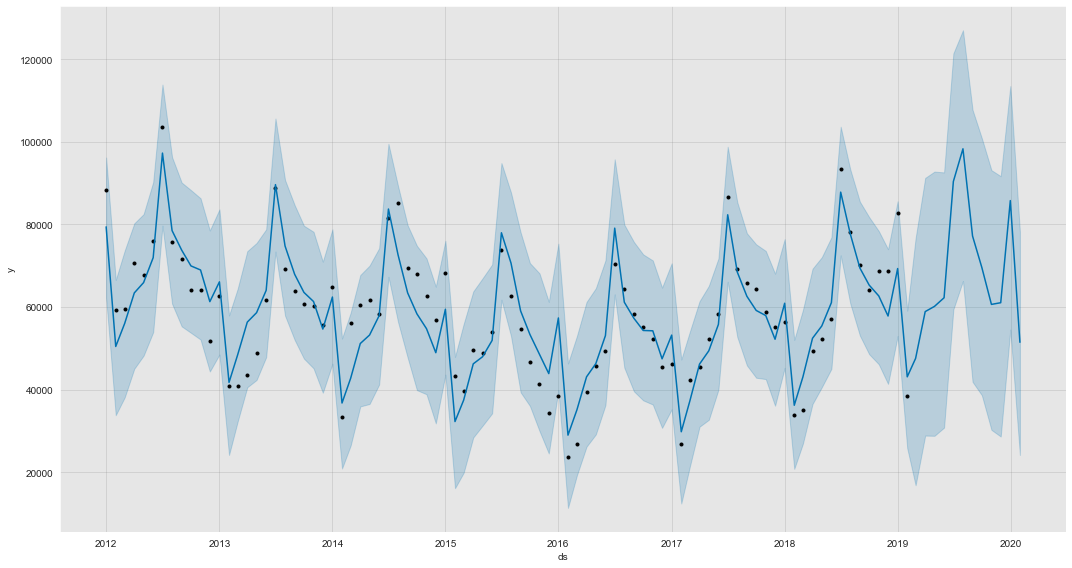

In [21]:
# Plotting the generated forecast
fig1 = model.plot(forecast, uncertainty=True, figsize=(15,8))

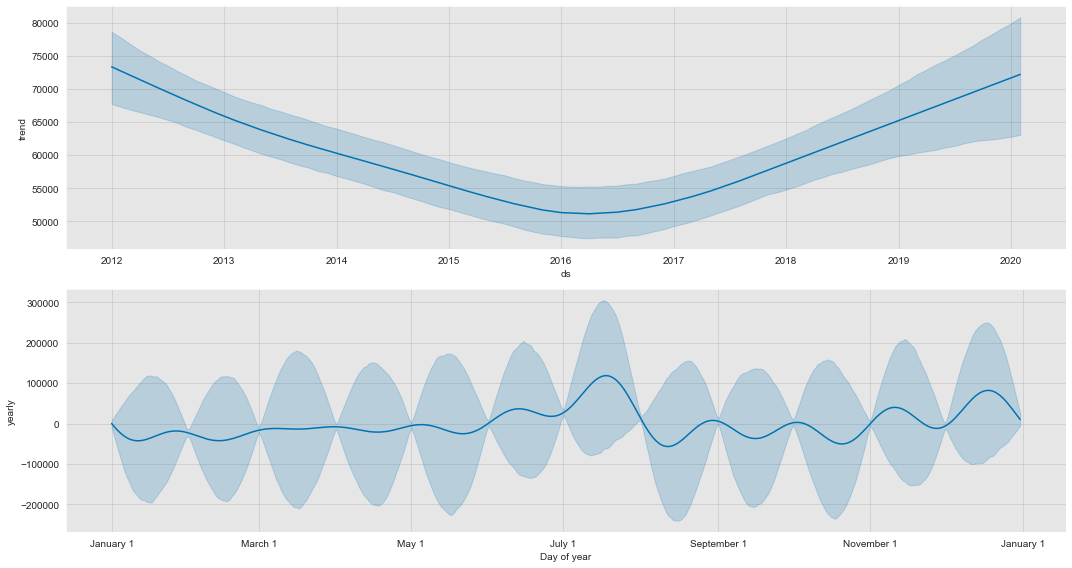

In [22]:
# Plotting the forecast components.
fig2 = model.plot_components(forecast, figsize=(15,8))

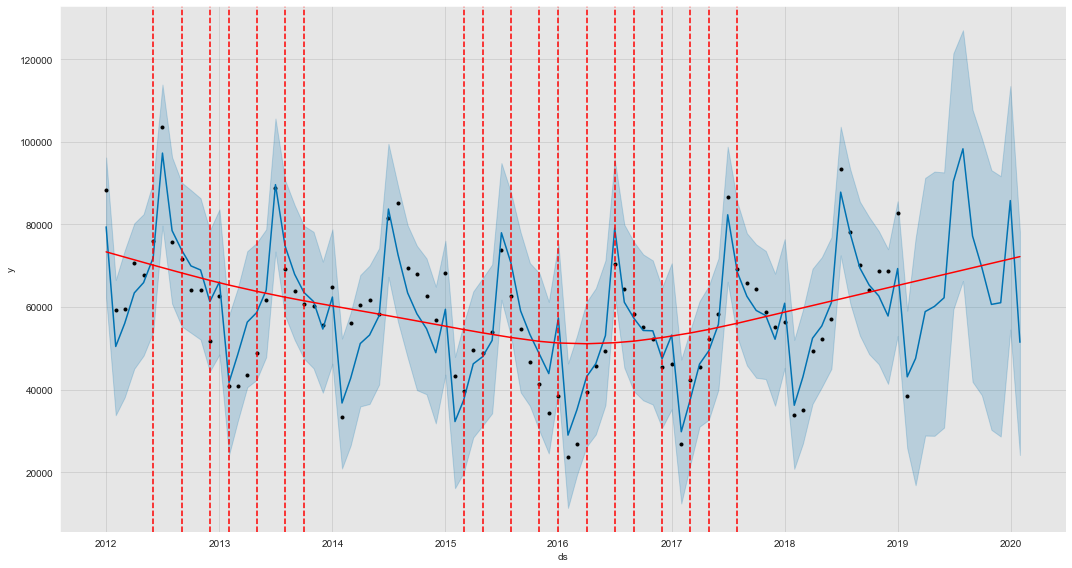

In [23]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model, forecast)

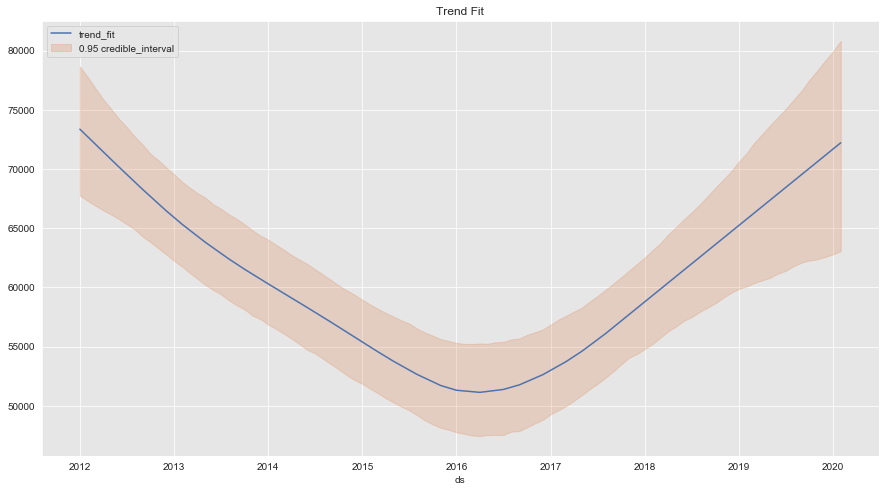

In [24]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

In [25]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(
    model=model, 
    initial='730 days',
    period='182.5 days', 
    horizon = '365 days'
)

df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2014-02-02 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds          yhat    yhat_lower     yhat_upper            y     cutoff
0 2014-03-01  39873.831556 -17260.510821   86954.964575  56193.43033 2014-02-02
1 2014-04-01  36164.295309 -23919.139301   84793.446282  60596.37253 2014-02-02
2 2014-05-01  49820.082455  -8644.768574   98127.454115  61649.01563 2014-02-02
3 2014-06-01  64148.241860   6718.970230  115247.169930  58450.61174 2014-02-02
4 2014-07-01  86051.382554  30216.556877  139027.831742  81486.12790 2014-02-02

In [26]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df=df_cv, rolling_window=0.1)

df_p#.head()

horizon           mse          rmse           mae      mape     mdape  coverage
0   58 days 00:00:00  1.631529e+08  12773.130167  11038.968275  0.218958  0.204490  1.000000
1   58 days 12:00:00  1.467295e+08  12113.196769  10291.510085  0.196405  0.204490  1.000000
2   59 days 00:00:00  1.337313e+08  11564.224809   9408.244808  0.174355  0.156632  1.000000
3   59 days 12:00:00  1.490152e+08  12207.177234  10260.117730  0.189017  0.181156  1.000000
4   88 days 00:00:00  1.441287e+08  12005.362674  10292.165797  0.194353  0.189982  1.000000
5   89 days 00:00:00  1.160652e+08  10773.356340   9256.643811  0.178478  0.189982  1.000000
6   89 days 12:00:00  1.181932e+08  10871.669221   9616.354442  0.184403  0.189982  1.000000
7   90 days 12:00:00  1.152541e+08  10735.646110   9726.837077  0.185945  0.189982  1.000000
8  119 days 00:00:00  8.530813e+07   9236.240009   8305.950877  0.160531  0.163346  1.000000
9  119 days 12:00:00  6.437877e+07   8023.638416   7312.712834  0.150392  0.141584  1.000000
10 120 days 00:00:00  6.309483e+07   7943.225312   7160.788164  0.142153  0.141584  1.000000
11 120 days 12:00:00  7.918036e+07   8898.334916   8026.946254  0.160651  0.169916  1.000000
12 149 days 00:00:00  7.668808e+07   8757.173092   7819.368120  0.150045  0.131960  1.000000
13 150 days 00:00:00  1.042366e+08  10209.632398   8747.833234  0.136541  0.131960  1.000000
14 150 days 12:00:00  1.495537e+08  12229.216864   9996.070636  0.177608  0.164119  0.900000
15 151 days 12:00:00  1.301032e+08  11406.280994   8764.217543  0.153850  0.092078  0.900000
16 180 days 00:00:00  2.492411e+08  15787.372834  11702.428587  0.191943  0.092078  0.800000
17 181 days 00:00:00  2.697494e+08  16424.049839  12726.979789  0.215112  0.138806  0.800000
18 181 days 12:00:00  2.391270e+08  15463.731445  11672.314528  0.221732  0.112724  0.850000
19 182 days 12:00:00  2.192170e+08  14805.979721  11401.449295  0.230408  0.173885  0.900000
20 209 days 12:00:00  2.484028e+08  15760.799885  12812.046771  0.267758  0.240348  0.900000
21 210 days 12:00:00  1.474998e+08  12144.949142  10254.728491  0.279773  0.328943  1.000000
22 211 days 00:00:00  1.781957e+08  13348.997378  11446.690312  0.303976  0.373067  1.000000
23 212 days 00:00:00  2.225272e+08  14917.345444  13501.276944  0.292663  0.338544  1.000000
24 240 days 12:00:00  2.245520e+08  14985.058856  13684.919056  0.286096  0.283817  1.000000
25 241 days 00:00:00  2.819705e+08  16791.976630  15284.191477  0.293064  0.283861  0.900000
26 241 days 12:00:00  2.386877e+08  15449.522175  13688.759957  0.252480  0.238339  0.900000
27 242 days 00:00:00  2.402988e+08  15501.575477  13428.574162  0.250440  0.215973  0.800000
28 270 days 12:00:00  2.425672e+08  15574.567903  13637.097892  0.260679  0.281761  0.800000
29 271 days 12:00:00  1.698672e+08  13033.309758  10809.395185  0.207492  0.229700  0.800000
30 272 days 00:00:00  2.112977e+08  14536.084303  12340.767967  0.239422  0.231841  0.700000
31 273 days 00:00:00  2.165176e+08  14714.537064  13094.623630  0.248950  0.224815  0.766667
32 301 days 12:00:00  1.939610e+08  13926.986622  12268.821822  0.236109  0.224815  0.800000
33 302 days 00:00:00  2.259331e+08  15031.070935  12912.695105  0.271322  0.224815  0.733333
34 302 days 12:00:00  2.136019e+08  14615.125431  12512.407457  0.255113  0.160860  0.750000
35 303 days 00:00:00  2.488309e+08  15774.375905  13683.404093  0.274380  0.270116  0.700000
36 331 days 12:00:00  2.320883e+08  15234.444311  12945.070693  0.259110  0.180994  0.700000
37 332 days 12:00:00  2.678550e+08  16366.276217  14832.487740  0.230930  0.219078  0.700000
38 333 days 00:00:00  3.809712e+08  19518.482673  17392.102859  0.304526  0.219078  0.666667
39 334 days 00:00:00  3.628974e+08  19049.865524  16959.181191  0.286828  0.217689  0.666667
40 362 days 12:00:00  4.406776e+08  20992.323225  18433.939771  0.305815  0.217689  0.600000
41 363 days 12:00:00  4.192039e+08  20474.468375  17626.867806  0.302860  0.237585  0.566667
42 364 days 00

In [27]:
df_p = performance_metrics(df=df_cv, rolling_window=0.0)

df_p.head()

horizon           mse          rmse           mae      mape     mdape  coverage
0 27 days 00:00:00  3.099058e+08  17604.141339  17560.361610  0.381764  0.381764       1.0
1 28 days 00:00:00  7.559587e+07   8694.588599   7489.559791  0.199077  0.197701       1.0
2 28 days 12:00:00  6.208062e+07   7879.125286   6451.274238  0.114007  0.114007       1.0
3 29 days 12:00:00  1.331423e+08  11538.730556  11329.792236  0.185328  0.185328       1.0
4 58 days 00:00:00  3.521947e+08  18766.849783  17399.254412  0.305956  0.305956       1.0

In [28]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

horizon           mae
0   27 days 00:00:00  17560.361610
1   28 days 00:00:00   7489.559791
2   28 days 12:00:00   6451.274238
3   29 days 12:00:00  11329.792236
4   58 days 00:00:00  17399.254412
5   58 days 12:00:00   8787.669747
6   59 days 00:00:00   4199.247016
7   59 days 12:00:00  13149.897848
8   88 days 00:00:00  14524.763659
9   89 days 00:00:00   8206.458017
10  89 days 12:00:00   5997.800171
11  90 days 12:00:00   9226.985608
12 119 days 00:00:00   6732.899749
13 119 days 12:00:00   6399.420622
14 120 days 00:00:00   6963.823171
15 120 days 12:00:00  11943.183340
16 149 days 00:00:00   6942.052007
17 150 days 00:00:00   9605.464044
18 150 days 12:00:00  13205.010182
19 151 days 12:00:00   3294.237788
20 180 days 00:00:00  24133.672896
21 181 days 00:00:00  12132.830705
22 181 days 12:00:00   6131.910807
23 182 days 12:00:00   6895.297821
24 209 days 12:00:00  17400.212550
25 210 days 12:00:00  11608.997897
26 211 days 00:00:00  18092.639811
27 212 days 00:00:00  13234.995254
28 240 days 12:00:00   8731.718937
29 241 days 00:00:00  22500.967329
30 241 days 12:00:00   8452.106800
31 242 days 00:00:00  13986.924122
32 270 days 12:00:00  15320.232561
33 271 days 12:00:00   8485.542174
34 272 days 00:00:00  16108.970711
35 273 days 00:00:00  14654.837225
36 301 days 12:00:00   5728.906033
37 302 days 00:00:00  15122.253788
38 302 days 12:00:00   9692.392857
39 303 days 00:00:00  19042.870507
40 331 days 12:00:00   7271.503227
41 332 days 12:00:00  18282.528027
42 333 days 00:00:00  22490.468452
43 334 days 00:00:00  14482.972398
44 362 days 12:00:00  33790.456306
45 363 days 12:00:00  11921.946542
46 364 days 00:00:00  17023.729677
47 365 days 00:00:00  10332.124206

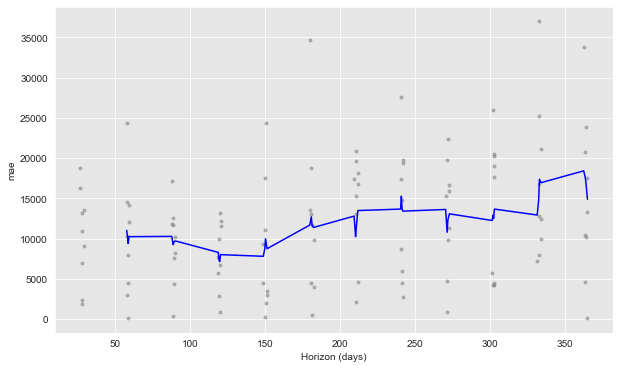

In [29]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv=df_cv, metric='mae', rolling_window=0.1)


# Multiples regresores prophet

In [30]:
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y'] + reg_cols]
df_test = df[~ mask][['ds', 'y'] + reg_cols]
print(df_train.shape)
print(df_test.shape)
df_test.tail()

(86, 15)
(12, 15)


ds        y     regr0      regr1      regr2      regr3     regr4     regr5      regr6     regr7        regr8  regr9     regr10  regr11  regr12
93 2019-10-01  67129.0  4.082545  40.133333  25.066667  10.633333  6.933333  4.466667  11.533333  1.033333  2235.666667   0.10  58.514548    22.0    13.0
94 2019-11-01  64563.0  4.155795  39.666667  24.433333  10.466667  6.766667  4.333333  11.266667  1.066667  2248.333333   0.51  59.727230    27.8    17.6
95 2019-12-01  68464.0  4.104486  39.200000  23.800000  10.300000  6.600000  4.200000  11.000000  1.100000  2261.000000   1.15  59.878494    29.5    18.0
96 2020-01-01  75454.0  4.151162  40.800000  24.900000  10.600000  6.900000  4.266667  11.400000  1.033333  2281.666667   0.21  59.989139    30.0    20.2
97 2020-02-01  44684.0  4.347016  42.400000  26.000000  10.900000  7.200000  4.333333  11.800000  0.966667  2302.333333   0.25  61.342562    29.6    19.3

In [31]:
# Fitting a Prophet model
model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95, 
        mcmc_samples = 500)

for col in reg_cols:
    model.add_regressor(col)
    
model.fit(df_train)

In [32]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')

future = future.merge(df[reg_cols ], left_index=True, right_index=True)

# Generate predictions. 
forecast = model.predict(df=future)

In [33]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

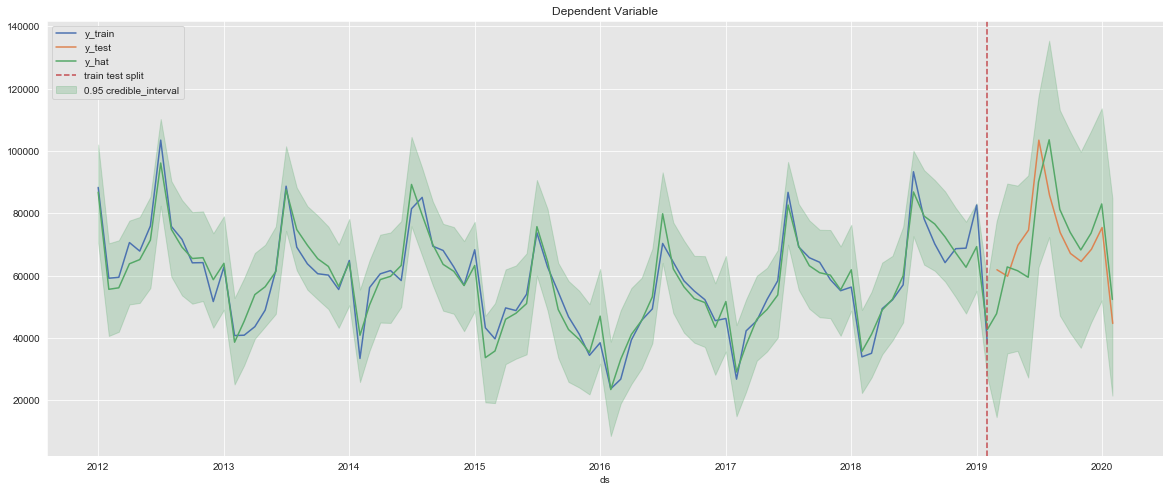

In [34]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

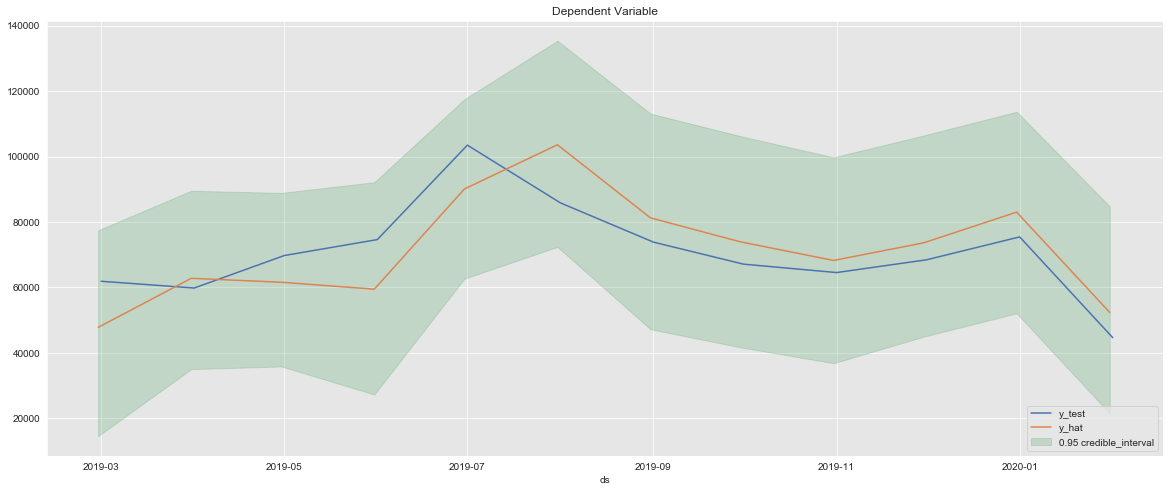

In [35]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

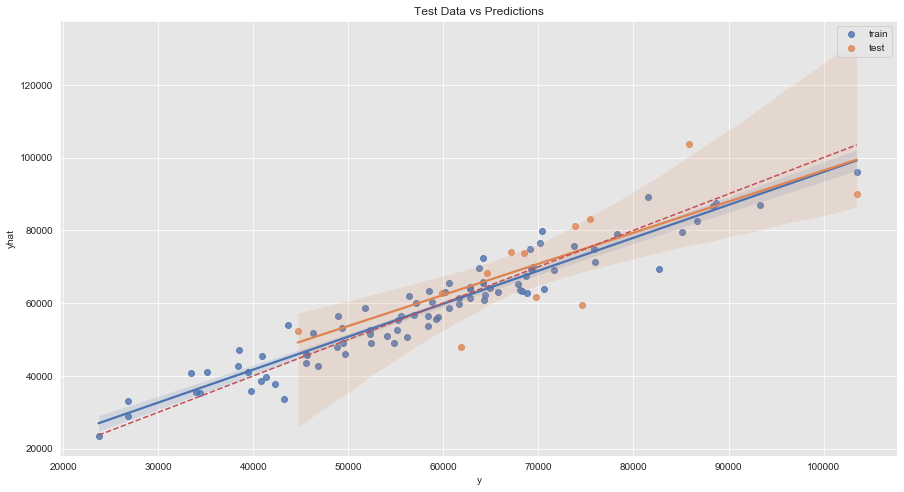

In [36]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))

r2 train: 0.9146111004942878
r2 test: 0.4493266151249701
------------------------------
mae train: 3616.8235787793515
mae test: 9155.786351640942


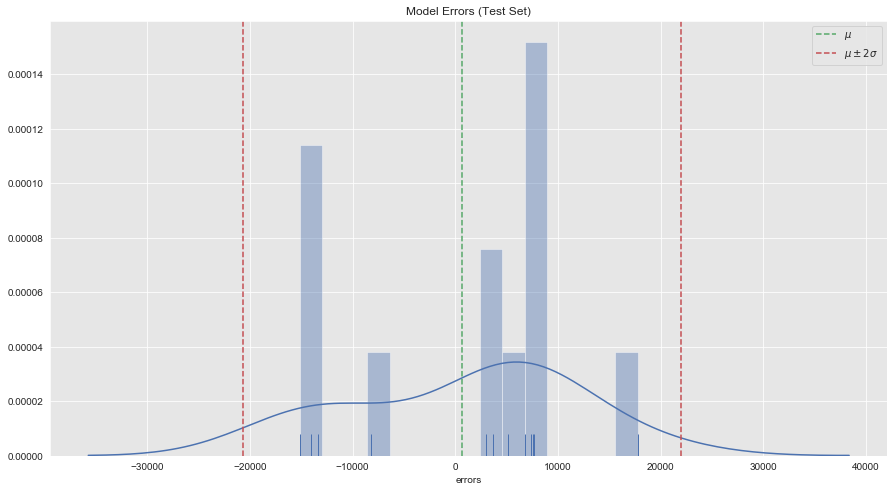

In [38]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

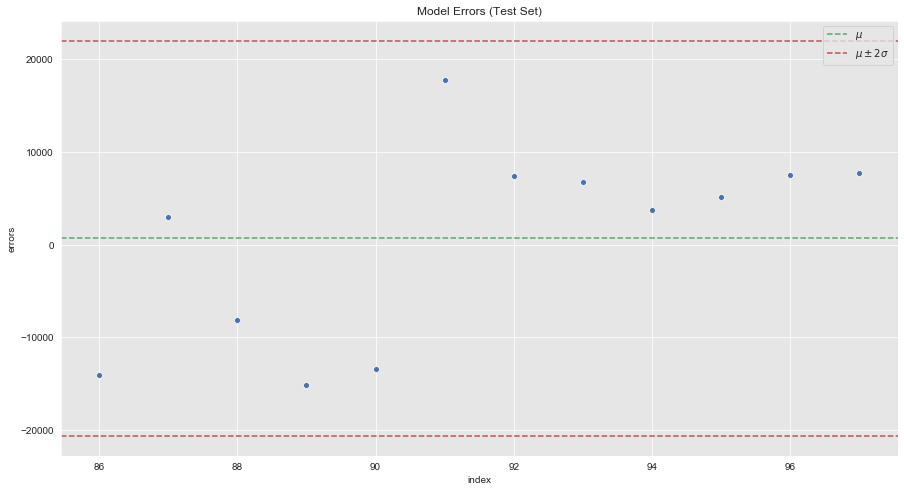

In [39]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

C:\Users\SanchezEdg\Anaconda3\envs\ev_nlp\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



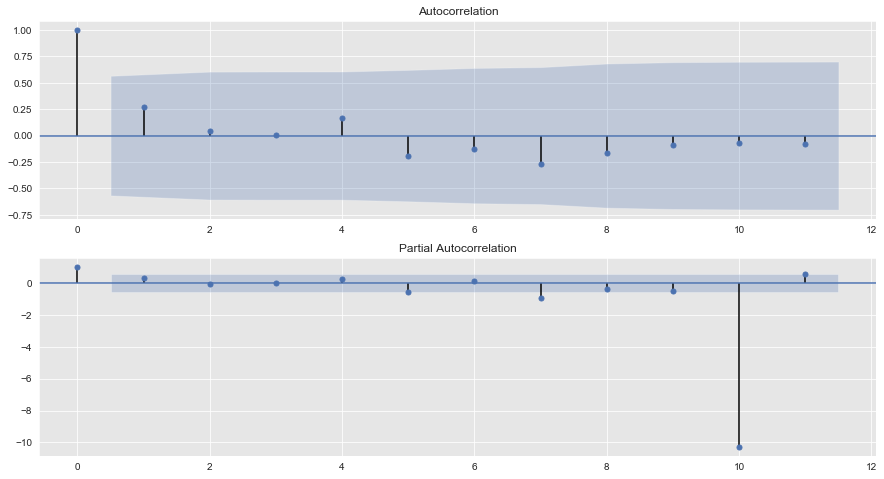

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

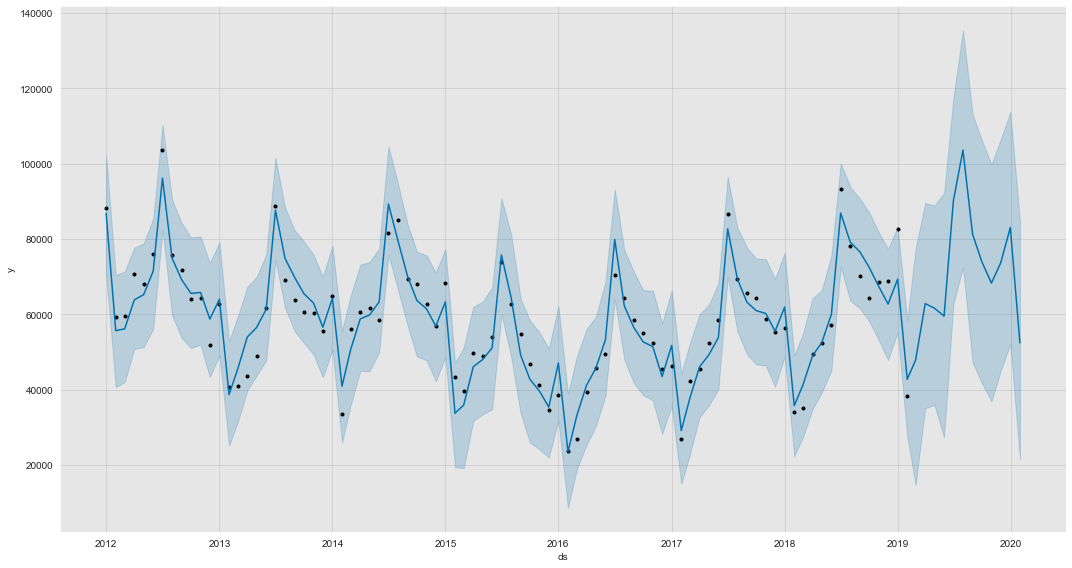

In [41]:
# Plotting the generated forecast
fig1 = model.plot(forecast, uncertainty=True, figsize=(15,8))

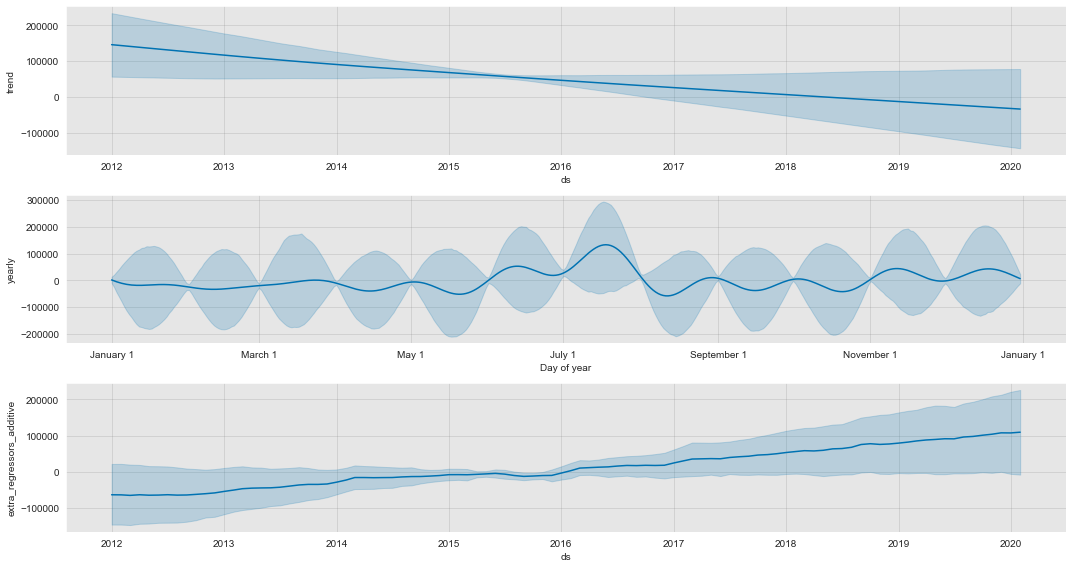

In [42]:
# Plotting the forecast components.
fig2 = model.plot_components(forecast, figsize=(15,8))

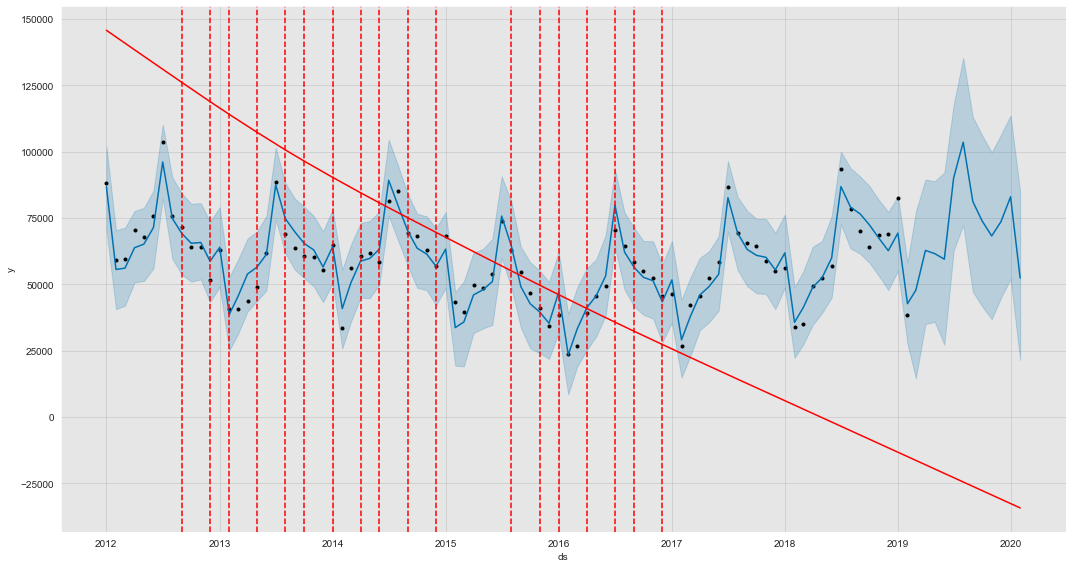

In [43]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model, forecast)

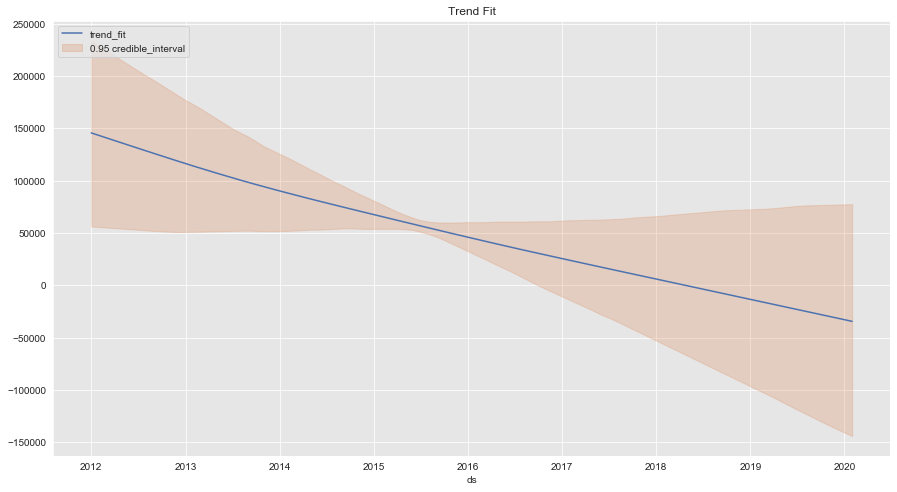

In [44]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

In [45]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(
    model=model, 
    initial='730 days',
    period='182.5 days', 
    horizon = '365 days'
)

df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2014-02-02 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds          yhat    yhat_lower    yhat_upper            y     cutoff
0 2014-03-01  36483.280641 -7.842542e+05  8.468582e+05  56193.43033 2014-02-02
1 2014-04-01  31671.583017 -9.044256e+05  9.967269e+05  60596.37253 2014-02-02
2 2014-05-01  43466.983899 -1.561715e+06  1.856875e+06  61649.01563 2014-02-02
3 2014-06-01  54936.230832 -2.287072e+06  2.705686e+06  58450.61174 2014-02-02
4 2014-07-01  73418.297916 -2.492807e+06  2.829452e+06  81486.12790 2014-02-02

In [46]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df=df_cv, rolling_window=0.1)

df_p#.head()

horizon           mse          rmse           mae      mape     mdape  coverage
0   58 days 00:00:00  3.801329e+08  19496.997099  15305.854417  0.318171  0.313941  1.000000
1   58 days 12:00:00  5.181380e+08  22762.644823  16866.465727  0.302916  0.281280  1.000000
2   59 days 00:00:00  5.476761e+08  23402.480604  18381.610567  0.334116  0.327285  1.000000
3   59 days 12:00:00  6.018753e+08  24533.146944  19791.455342  0.360508  0.378899  0.900000
4   88 days 00:00:00  5.782221e+08  24046.250007  19713.007389  0.361044  0.333012  0.900000
5   89 days 00:00:00  4.379492e+08  20927.235648  18960.031503  0.382590  0.351842  0.900000
6   89 days 12:00:00  1.185493e+09  34430.986999  25660.980681  0.474408  0.392888  0.900000
7   90 days 12:00:00  1.208411e+09  34762.212490  26068.432283  0.477479  0.351842  0.850000
8  119 days 00:00:00  1.137201e+09  33722.405312  23228.431641  0.425977  0.351842  0.900000
9  119 days 12:00:00  3.671151e+09  60590.023301  36169.598967  0.657203  0.336836  0.900000
10 120 days 00:00:00  3.668970e+09  60572.022022  37670.352447  0.689704  0.373161  0.800000
11 120 days 12:00:00  3.401992e+09  58326.599623  35712.195697  0.676607  0.436343  0.750000
12 149 days 00:00:00  3.368903e+09  58042.256064  35135.694567  0.657505  0.373161  0.800000
13 150 days 00:00:00  1.291872e+09  35942.619905  30189.175042  0.492301  0.436343  0.700000
14 150 days 12:00:00  1.610007e+09  40124.890146  31223.852129  0.479468  0.400971  0.766667
15 151 days 12:00:00  1.417767e+09  37653.240759  28362.449725  0.425627  0.234286  0.750000
16 180 days 00:00:00  1.673915e+09  40913.503936  33588.824309  0.483822  0.430194  0.800000
17 181 days 00:00:00  1.579448e+09  39742.263883  33562.322344  0.499245  0.460411  0.866667
18 181 days 12:00:00  1.140143e+09  33765.998956  28069.141938  0.453595  0.475868  0.900000
19 182 days 12:00:00  8.224914e+08  28679.110742  24707.562441  0.449458  0.435673  0.950000
20 209 days 12:00:00  7.850243e+08  28018.285551  23107.089242  0.416040  0.435673  1.000000
21 210 days 12:00:00  4.536981e+08  21300.189799  16370.016275  0.376419  0.306228  0.900000
22 211 days 00:00:00  3.892980e+08  19730.635512  15172.287773  0.372348  0.268080  0.900000
23 212 days 00:00:00  5.997337e+08  24489.461716  19534.748339  0.381898  0.320693  0.900000
24 240 days 12:00:00  6.113740e+08  24725.978066  20275.155451  0.375032  0.320693  0.900000
25 241 days 00:00:00  8.083411e+08  28431.339291  24633.592540  0.452261  0.392147  0.933333
26 241 days 12:00:00  7.667925e+08  27691.017972  24129.405196  0.445802  0.392147  1.000000
27 242 days 00:00:00  7.322085e+08  27059.351125  22537.167155  0.421853  0.457169  1.000000
28 270 days 12:00:00  1.045702e+09  32337.310160  26127.459343  0.511613  0.457169  1.000000
29 271 days 12:00:00  1.013899e+09  31841.784596  26203.668108  0.516856  0.484409  1.000000
30 272 days 00:00:00  1.234345e+09  35133.240836  28590.225661  0.575297  0.484445  1.000000
31 273 days 00:00:00  1.413892e+09  37601.752655  31056.220162  0.601121  0.583682  1.000000
32 301 days 12:00:00  2.307512e+09  48036.573954  38706.164444  0.749129  0.648678  1.000000
33 302 days 00:00:00  2.017831e+09  44920.272616  34425.444702  0.700238  0.418426  1.000000
34 302 days 12:00:00  2.297629e+09  47933.587724  37762.233853  0.743281  0.399969  1.000000
35 303 days 00:00:00  2.511998e+09  50119.836802  41385.617494  0.794304  0.544580  0.900000
36 331 days 12:00:00  2.762434e+09  52558.864464  44657.047104  0.832899  0.730047  0.900000
37 332 days 12:00:00  2.181860e+09  46710.384067  42690.319042  0.671942  0.544580  0.900000
38 333 days 00:00:00  1.956432e+09  44231.568821  39721.749631  0.639618  0.544580  0.900000
39 334 days 00:00:00  1.982107e+09  44520.857555  37730.668579  0.562884  0.631837  0.866667
40 362 days 12:00:00  3.115091e+09  55813.002881  45220.664585  0.677709  0.631837  0.900000
41 363 days 12:00:00  2.618797e+09  51174.179595  39584.957985  0.616273  0.409970  0.900000
42 364 days 00

In [47]:
df_p = performance_metrics(df=df_cv, rolling_window=0.0)

df_p.head()

horizon           mse          rmse           mae      mape     mdape  coverage
0 27 days 00:00:00  1.492101e+09  38627.721696  35329.138940  0.816404  0.816404       1.0
1 28 days 00:00:00  1.355402e+08  11642.174060   9521.909335  0.263582  0.282675       1.0
2 28 days 12:00:00  8.105634e+07   9003.129720   8204.712951  0.141052  0.141052       1.0
3 29 days 12:00:00  2.038930e+08  14279.111049  10778.469613  0.183344  0.183344       1.0
4 58 days 00:00:00  6.663544e+08  25813.840381  25598.656046  0.462886  0.462886       1.0

In [48]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

horizon            mae
0   27 days 00:00:00   35329.138940
1   28 days 00:00:00    9521.909335
2   28 days 12:00:00    8204.712951
3   29 days 12:00:00   10778.469613
4   58 days 00:00:00   25598.656046
5   58 days 12:00:00   30228.580690
6   59 days 00:00:00   14133.326672
7   59 days 12:00:00   16540.815158
8   88 days 00:00:00   17796.323067
9   89 days 00:00:00   26175.352853
10  89 days 12:00:00   47638.072562
11  90 days 12:00:00   17374.328926
12 119 days 00:00:00    2968.565903
13 119 days 12:00:00   86691.674590
14 120 days 00:00:00   38332.104354
15 120 days 12:00:00   22715.416995
16 149 days 00:00:00    7288.941769
17 150 days 00:00:00   42295.573275
18 150 days 12:00:00   43505.489790
19 151 days 12:00:00   16216.748656
20 180 days 00:00:00   41134.052301
21 181 days 00:00:00   30538.356224
22 181 days 12:00:00   15434.629503
23 182 days 12:00:00   13053.221735
24 209 days 12:00:00     212.016671
25 210 days 12:00:00   15145.243719
26 211 days 00:00:00   24549.713712
27 212 days 00:00:00   29182.362135
28 240 days 12:00:00   20457.292851
29 241 days 00:00:00   29470.815638
30 241 days 12:00:00   16599.442570
31 242 days 00:00:00   22330.685860
32 270 days 12:00:00   65085.284011
33 271 days 12:00:00   26720.337259
34 272 days 00:00:00   28532.230336
35 273 days 00:00:00   28640.253101
36 301 days 12:00:00   98830.128681
37 302 days 00:00:00   24499.211924
38 302 days 12:00:00   38446.932121
39 303 days 00:00:00   40682.190982
40 331 days 12:00:00   61354.549202
41 332 days 12:00:00   42720.423970
42 333 days 00:00:00   23604.085063
43 334 days 00:00:00   33300.167855
44 362 days 12:00:00  115582.151049
45 363 days 12:00:00   30146.110378
46 364 days 00:00:00   15827.848483
47 365 days 00:00:00   35932.290647

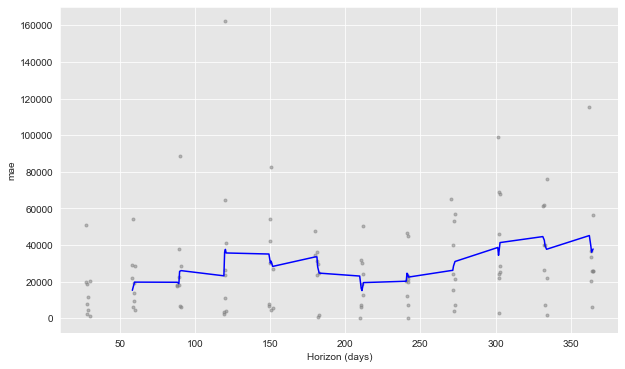

In [49]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv=df_cv, metric='mae', rolling_window=0.1)


# Pruebas

In [50]:
# Python
invierno = pd.DataFrame({
  'holiday': 'invierno',
  'ds': pd.date_range(start=pd.datetime(2010,6,1), periods=10, freq=pd.DateOffset(years=1)),
  'lower_window': 0,
  'upper_window': 0,
})

verano = pd.DataFrame({
  'holiday': 'verano',
  'ds': pd.date_range(start=pd.datetime(2010,12,1), periods=10, freq=pd.DateOffset(years=1)),
  'lower_window': 0,
  'upper_window': 0,
})

carnaval = pd.DataFrame({
  'holiday': 'carnaval',
  'ds': pd.date_range(start=pd.datetime(2010,2,1), periods=10, freq=pd.DateOffset(years=1)),
  'lower_window': 0,
  'upper_window': 0,
})

holidays= pd.concat((verano, invierno,carnaval))
holidays

C:\Users\SanchezEdg\Anaconda3\envs\ev_nlp\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

C:\Users\SanchezEdg\Anaconda3\envs\ev_nlp\lib\site-packages\ipykernel_launcher.py:11: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

C:\Users\SanchezEdg\Anaconda3\envs\ev_nlp\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



holiday         ds  lower_window  upper_window
0    verano 2010-12-01             0             0
1    verano 2011-12-01             0             0
2    verano 2012-12-01             0             0
3    verano 2013-12-01             0             0
4    verano 2014-12-01             0             0
5    verano 2015-12-01             0             0
6    verano 2016-12-01             0             0
7    verano 2017-12-01             0             0
8    verano 2018-12-01             0             0
9    verano 2019-12-01             0             0
0  invierno 2010-06-01             0             0
1  invierno 2011-06-01             0             0
2  invierno 2012-06-01             0             0
3  invierno 2013-06-01             0             0
4  invierno 2014-06-01             0             0
5  invierno 2015-06-01             0             0
6  invierno 2016-06-01             0             0
7  invierno 2017-06-01             0             0
8  invierno 2018-06-01             0             0
9  invierno 2019-06-01             0             0
0  carnaval 2010-02-01             0             0
1  carnaval 2011-02-01             0             0
2  carnaval 2012-02-01             0             0
3  carnaval 2013-02-01             0             0
4  carnaval 2014-02-01             0             0
5  carnaval 2015-02-01             0             0
6  carnaval 2016-02-01             0             0
7  carnaval 2017-02-01             0             0
8  carnaval 2018-02-01             0             0
9  carnaval 2019-02-01             0             0

In [51]:
# adding regressor data in historical and future dates
df_train3 = (df[['ds', 'y']+reg_cols]
             .iloc[:80]
             .copy())
df_predict3 = df[['ds']+reg_cols].copy()
# modelling external regressors prior to model fitting
model3 = Prophet(seasonality_mode='multiplicative', holidays=invierno)

for col in reg_cols:
    model3.add_regressor(col)

# fit and predcit
model3.fit(df_train3)
forecast3 = model3.predict(df_predict3)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.ds, y=df.y, name="Real")
)

fig.add_trace(
    go.Scatter(x=forecast3.ds, y=forecast3.yhat, name="Forecast")
)

# Add figure title
fig.update_layout(
    template="presentation"
)
fig.show()


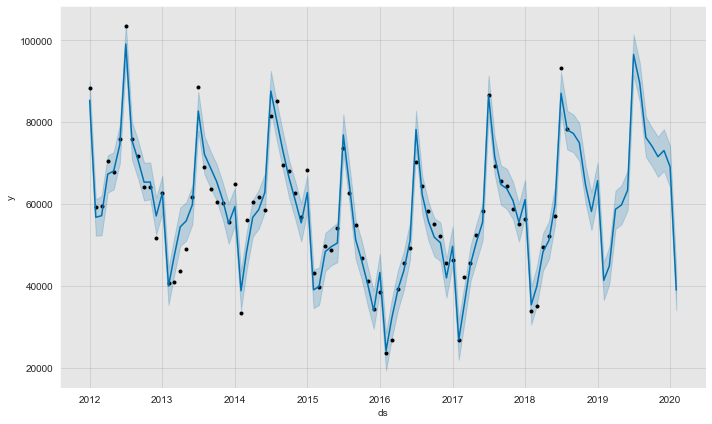

In [53]:
# Plot the forecast
fig1 = model3.plot(forecast3, uncertainty=True)

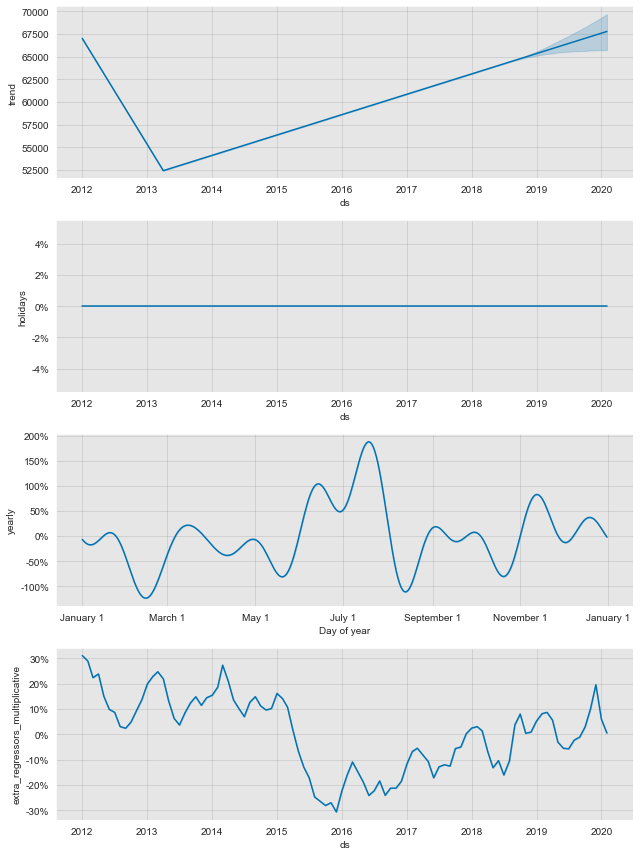

In [54]:
# plot model components
fig2 = model3.plot_components(forecast3, uncertainty=True)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics

# adding regressor data in historical and future dates
df_train3 = (df[['ds', 'y']+reg_cols]
             .copy())

model3 = Prophet(seasonality_mode='multiplicative', holidays=invierno)

for col in reg_cols:
    model3.add_regressor(col)

# fit and predcit
model3.fit(df_train3)



df_cv = cross_validation(model3, horizon='180 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 25 forecasts with cutoffs between 2013-09-05 00:00:00 and 2019-08-05 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')


In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=df.ds, y=df.y, name="Real")
# )

# fig.add_trace(
#     go.Scatter(x=forecast.ds, y=forecast.yhat, name="Forecast")
# )

# # Add figure title
# fig.update_layout(
#     template="presentation"
# )
# fig.show()


In [ ]:
np.random.seed(seed=42)

def generate_time_series_df(start_date, end_date, freq):
    """Generate time series sample data."""
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

    df = pd.DataFrame(data={'ds': date_range})
    
    # Get date variables. 
    df['day_of_month'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['daysinmonth'] = df['ds'].dt.daysinmonth
    df['week'] = df['ds'].dt.week
    
    # Time Series Components 
    ## Trend
    df['trend'] = np.power(df.index.values + 1, 2/5) + np.log(df.index.values + 3)
    ## Seasonal
    df['monthly_seas'] = np.cos(2*np.pi*df['day_of_month']/df['daysinmonth'])
    df['yearly_seas'] = 1.2*(np.sin(np.pi*df['month']/3) + np.cos(2*np.pi*df['month']/4))
    df['end_of_year']= - 8.5*np.exp(- ((df['week'] - 51.5)/1.0)**2) \
    ## Gaussian noise
    df['noise'] = np.random.normal(loc=0.0, scale=0.3, size=df.shape[0])
    
    # Target variable.
    df['y'] = df['trend'] \
        + df['monthly_seas'] \
        + df['yearly_seas'] \
        + df['end_of_year'] \
        + df['noise']
    
    return df

df = generate_time_series_df(
    start_date='2016-06-30', 
    end_date='2020-10-31', 
    freq='W'
)

df.head()

In [ ]:
# Define threshold date.
threshold_date = pd.to_datetime('2019-11-01')
mask = df['ds'] < threshold_date
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]

In [ ]:
print(df.shape[0])
print(df_train.shape[0])
print(df_test.shape[0])

In [ ]:
def create_end_of_year_holydays_df():
    """Create holidays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2016-12-25', '2017-12-24', '2018-12-23', '2019-12-22']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays

In [ ]:
def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holydays_df()
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
        mcmc_samples = 500
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
    return model
    
model = build_model()

In [ ]:
# We train the model with the training data. 
model.fit(df_train)


In [ ]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='W')
# Generate predictions. 
forecast = model.predict(df=future)

In [ ]:
future